In [15]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv

In [5]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31") #"GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"

[*********************100%***********************]  6 of 6 completed


In [6]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2010-01-04  6.526020  24.106220  19.280523  32.229889  15.610239  39.131069   
2010-01-05  6.537303  23.740726  19.436930  32.749943  15.541497  38.881393   
2010-01-06  6.433320  23.891222  19.737720  32.407475  15.149715  38.807625   
2010-01-07  6.421425  23.732666  19.912174  32.553345  14.797037  38.643066   
2010-01-08  6.464117  23.660107  19.644474  33.739288  14.994298  38.586319   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   
2010-01-08  7.570714  44.020000  32.654999  41.323200  ...  33.334999   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   
2010-01-08  40.740635  14.744733  68.133118  447610800.0  3307737.0   

                                                           
               BMW.DE      DBK.DE         GOOG     RWE.DE  
Date                                                       
2010-01-04  1808170.0   4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0   5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0   5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0   4506202.0  257533695.0  1765257.0  
2010-01-08  1925894.0  10753806.0  189680313.0  1665122.0  

[5 rows x 36 columns]

In [7]:
data = data["Adj Close"]

In [8]:
data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0), columns=data.columns)

In [9]:
data = data.dropna(axis=0)

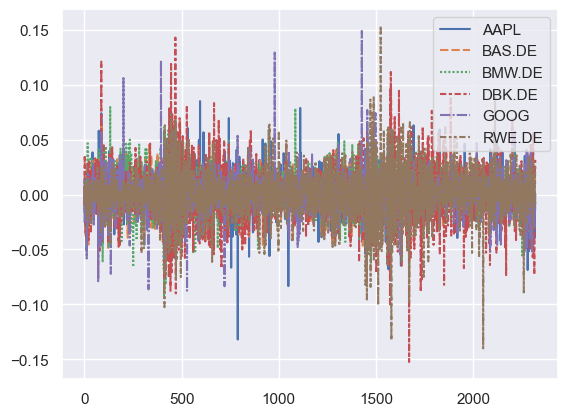

In [10]:
sns.lineplot(data = data);

In [11]:
np.mean(data.iloc[0])

-0.0053835562381661095

In [12]:
data.iloc[0]

AAPL     -0.016034
BAS.DE    0.006319
BMW.DE    0.015357
DBK.DE   -0.010512
GOOG     -0.025532
RWE.DE   -0.001899
Name: 0, dtype: float64

In [13]:
PF = data.mean(axis=1)

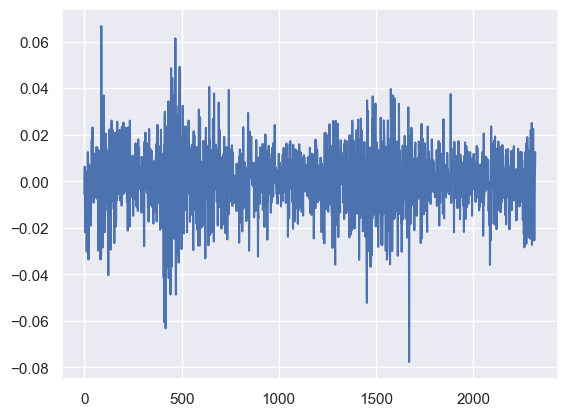

In [14]:
sns.lineplot(x = PF.index, y = PF);

# ARMA-GARCH

# Copula VaR

In [18]:
u = pv.to_pseudo_obs(data)

In [20]:
cop = pv.Vinecop(u)

In [22]:
cop.aic()

-4681.066535596574

In [26]:
cop.families

[[<BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.student: 2>,
  <BicopFamily.student: 2>,
  <BicopFamily.tll: 11>],
 [<BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>],
 [<BicopFamily.tll: 11>, <BicopFamily.bb8: 10>, <BicopFamily.frank: 5>],
 [<BicopFamily.tll: 11>, <BicopFamily.tll: 11>],
 [<BicopFamily.joe: 6>]]

In [30]:
cop.structure

<pyvinecopulib.RVineStructure>
5 2 2 2 6 6 
2 4 4 6 2 
4 3 6 4 
3 6 3 
6 5 
1 

In [32]:
cop.simulate(100)

array([[9.89085504e-02, 5.18081394e-01, 1.60940622e-01, 2.78602778e-01,
        2.01610478e-02, 8.46752757e-01],
       [5.27582469e-01, 7.05989231e-01, 8.92115987e-01, 5.73355577e-01,
        4.98820105e-01, 7.51053038e-01],
       [4.51645045e-01, 5.92507989e-02, 1.93346452e-01, 1.18718224e-02,
        2.34052346e-01, 7.43097671e-02],
       [5.11831792e-01, 4.87654112e-01, 3.40121130e-01, 5.17338013e-01,
        4.37528942e-01, 8.36793453e-01],
       [9.59347013e-01, 3.81250511e-01, 4.88267195e-01, 3.03315853e-01,
        9.14724671e-01, 9.79864502e-01],
       [5.97340171e-01, 9.22778091e-01, 9.51785656e-01, 6.12879976e-01,
        1.62632539e-01, 9.67824541e-01],
       [8.35101651e-01, 2.04475783e-02, 1.48352491e-01, 4.90495544e-02,
        3.29932505e-01, 5.20351313e-02],
       [2.64389259e-01, 1.70583810e-01, 2.63654353e-01, 1.40512270e-01,
        2.47428729e-01, 1.14792188e-02],
       [8.29475685e-01, 6.04051849e-01, 7.90949843e-01, 9.59166491e-01,
        9.46067465e-01, 